# Step 1: Set Desired Values

In [ ]:
dataset_dir = 'data/imagenet'
image_or_grid = 'grid' if 'grid' in dataset_dir else 'images'
sigmas = [0.15]
sigmas = [f'sigma_{sigma}' for sigma in sigmas]
xai_methods = ['Grad', 'LRP', 'RISE', 'GradCam', 'GradCamPlusPlus']
layers = ['Input', 'Final']
model = 'resnet18'
image_indices = sorted([163]) # Nemo
samples_dir = f'outputs/noisy_samples_chunks/{image_or_grid}'
save_dir = 'figures'
os.makedirs(save_dir, exist_ok=True)
attr_dict = {sigma: {layer: {xai: {} for xai in xai_methods} for layer in layers} for sigma in sigmas}

# Step 2: Load ImageNet Dataset (first 200 images)

In [22]:
import torch
import torchvision
import os
from attribution_evaluation.evaluation import utils
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
import torch
import pickle
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_rgba
import matplotlib

%matplotlib inline
seed = 73
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
current_directory = os.getcwd()
if 'experiments' in current_directory:
    parent_directory = os.path.dirname(current_directory)
    os.chdir(parent_directory)
    
from scripts.utils import *

def load_dataset(dataset_dir, max_images=200):
    test_data_dict = torch.load(os.path.join(dataset_dir, 'test.pt'))
    scale = test_data_dict["scale"]
    img_dims = test_data_dict["input_dims"][1:]
    imagenet_inv_normalize_transform = torchvision.transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    shuffled_idx = pickle.load(open('data/images_indices.pkl', 'rb'))
    images = imagenet_inv_normalize_transform(test_data_dict["data"][shuffled_idx][:max_images])
    return images, img_dims, scale

dataset_dir = 'data/imagenet'
images, img_dims, scale = load_dataset(dataset_dir, max_images=200)

# Step 3: Load noisy attribution samples (100 samples per image)

In [29]:
caching_dir = 'metadata_dict'
for sigma in sigmas:
    for layer in layers:
        for xai_method in tqdm(xai_methods):
            if 'Cam' in xai_method and layer == 'Input': continue
            if 'Cam' not in xai_method and layer == 'Final': continue
            noisy_samples, raw = fast_load(os.path.join(samples_dir, sigma, layer, xai_method), model=model, im_indices=image_indices)
            raw, scale_factor = process_attributions(raw, 
                                steps_dict=
                                { 
                                'interpolate': {'img_dims': tuple(img_dims), 'scale': scale},
                                'normalize':  {'clip_percentile': 99.5, 'scale_factor': None},
                                'positive': {},
                                })
            noisy_samples = process_attributions(noisy_samples, 
                                steps_dict=
                                {
                                'interpolate': {'img_dims': tuple(img_dims), 'scale': scale},
                                'normalize':   {'clip_percentile': 99.5, 'scale_factor': scale_factor},
                                'positive': {},
                                },
                                return_scale=False)
            attr_dict[sigma][layer][xai_method]['raw'] = raw
            attr_dict[sigma][layer][xai_method]['noisy_samples'] = noisy_samples             

100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


# Step 4: Certify attributions based on the sparsification values Ks, number of samples n and $\tau$

In [30]:
Ks = [50, 25, 5]
ns = [100]
taus = [0.75]
graph_dict = {sigma: {layer:{xai: {K: {n: {tau: {} for tau in taus} for n in ns} for K in Ks} for xai in xai_methods} for layer in layers} for sigma in sigmas}
for sigma, sigma_dict in attr_dict.items():
    for layer, layer_d in sigma_dict.items():
        for xai_method, xai_d in layer_d.items():
            if 'Cam' in xai_method and layer == 'Input': continue
            if 'Cam' not in xai_method and layer == 'Final': continue
            for K in Ks:
                for n in ns:
                    for tau in taus:
                        if 'certified' in graph_dict[sigma][layer][xai_method][K][n][tau]: continue
                        noisy_samples = attr_dict[sigma][layer][xai_method]['noisy_samples']
                        sparsified = process_attributions(noisy_samples, 
                                steps_dict={'sparsify': {'spars_method': 'all_percentile', 'spars_param': [K], 'head_idx': 0}}, return_scale=False)
                        certified = process_attributions(sparsified, 
                                steps_dict={'certify': {'n':n, 'n0':10, 'tau':tau, 'alpha': 0.001, 'head_idx':0}}, return_scale=False)
                        graph_dict[sigma][layer][xai_method][K][n][tau]['certified'] = certified.cpu().numpy()
                        graph_dict[sigma][layer][xai_method][K][n][tau]['raw_spars'] = sparsified.cpu().numpy()
                        graph_dict[sigma][layer][xai_method][K][n][tau]['sparsified'] = sparsified.cpu().numpy()

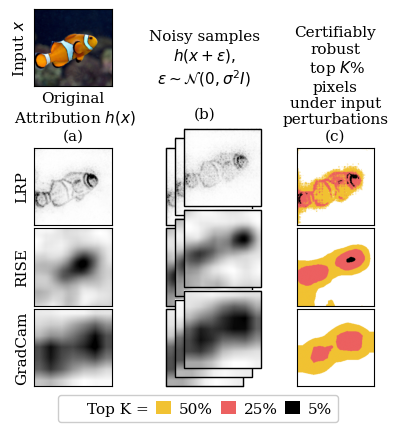

In [ ]:
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib.patches import Rectangle

fontsize = 11
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)

color_list = [mcolors.to_rgba(color) for color in ['#f1c232', '#ec6060', '#7a5d66', '#842E6A', '#413069', '#000000', '#000000']][:len(Ks)]
color_list[len(Ks)-1] = mcolors.to_rgba('black')
colors = {
'abstain': (0.85, 0.85, 0.85, 1),
'bg': (1, 1, 1, 1),
'greens': custom_greens,
'darkgreen': (0.0, 0.39, 0.0, 1.0),
'greens':  LinearSegmentedColormap.from_list("custom_greens", [(1, 1, 1)] + [plt.cm.Greens(i) for i in range(plt.cm.Greens.N)], N=plt.cm.Greens.N),
'inferno': ListedColormap(color_list, name="inferno_custom"),
'inferno_ls': color_list
}
#cols = ['raw']  +['noisy_sample'] + ['dots'] + ['noisy_sample'] + ['overlayed']
cols = ['raw']  + ['stacked'] + ['overlayed']
image_indices = [163]
im_idx_d = {}
for i, x in enumerate(image_indices):
    im_idx_d[x] = i
for x in image_indices:
    im_idx = x
    sigma = 0.15

    os.makedirs(save_dir, exist_ok=True)
    sigma, layer,  n, K = f'sigma_{sigma}', 'Input',  100, Ks[0]

    fig = plt.figure(figsize=(len(cols)+2, len(xai_methods)+2))
    width_ratios = [0.03 if x == 'dots' else 1 if x == 'stacked' else 1 for x in cols]
    gs = gridspec.GridSpec(len(xai_methods)+2, len(cols), 
                            height_ratios=[1, 0.7] + [1]*len(xai_methods),  # 0.3 = blank spacer row
                        width_ratios=width_ratios)  # Adjust column widths
    im = images[im_idx].cpu().numpy().transpose(1, 2, 0)
    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(im)
    ax.set_ylabel('Input $x$')
    for idx, xai_method in enumerate([ 'LRP', 'RISE', 'GradCam']):
        method_idx = idx + 2
        if 'Cam' in xai_method: layer='Final'
        else: layer = 'Input'
        for col_idx, col_type in enumerate(cols):
            ax = fig.add_subplot(gs[method_idx, col_idx])
            if col_type == 'raw':
                raw = attr_dict[sigma][layer][xai_method]['raw'][im_idx_d[im_idx]].squeeze()
                ax.imshow(raw, cmap=plt.cm.binary)
                if col_idx == 0:
                    ax.set_ylabel(xai_method)
                if method_idx == 2:
                    ax.set_title('Original\n Attribution $h(x)$\n(a)', fontsize=fontsize)

            elif col_type == 'noise':
                noisy_image = torch.clip((images[im_idx]*0 + 1 * torch.randn_like(images[im_idx]))*255, 0, 1).cpu().numpy().transpose(1, 2, 0)
                ax.imshow(noisy_image)
            elif col_type == 'dots':
                ax.axis('off')
                if method_idx == 2:
                    ax.set_title('Noisy samples\n' + r'$h(x+\epsilon),$'+'\n'+r'$\epsilon \sim \mathcal{N}(0, \sigma^2 I)$'+'\n(b)',
                    fontsize=fontsize, loc='center', pad=10)

                ax.text(0.5, 0.5, '...', fontsize=16, ha='center', va='center')
            elif col_type == 'stacked':
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                #ax.axis('off')

                num_samples = 3
                offset = 0.12  # how far up/right to shift each image
                size = 1.0    # full image size

                for j in range(num_samples):
                    rand_idx = random.randint(0, n-1)
                    sample = attr_dict[sigmas[-1]][layer][xai_method]['noisy_samples'][im_idx_d[im_idx]][rand_idx].squeeze()

                    # Normalize
                    sample = (sample - sample.min()) / (sample.max() - sample.min() + 1e-8)

                    # Diagonal **up** stacking — increase y with each step
                    x0 = j * offset
                    y0 = j * offset

                    # Later samples should overlay earlier → higher zorder for later
                    z = 10 + j  # increasing zorder

                    ax.imshow(sample, cmap=plt.cm.binary, extent=(x0, x0 + size, y0, y0 + size),
                            zorder=z, clip_on=False)
                    # Add white border
                    # Full black border
                    ax.add_patch(plt.Rectangle(
                        (x0, y0), size, size,
                        linewidth=1,
                        edgecolor='black',
                        facecolor='none',
                        zorder=z + 0.4,
                        clip_on=False
                    ))
                    # if method_idx != 2:
                    #     ax.plot(
                    #         [x0, x0 + size],       # x-coords: left to right
                    #         [y0 + size, y0 + size],  # y-coord: top edge of image
                    #         color='white',
                    #         linewidth=2.0,
                    #         zorder=z + 0.5,
                    #         clip_on=False
                    #     )
                if method_idx == 2:
                    ax.set_title('Noisy samples\n' + r'$h(x+\epsilon),$'+'\n'+r'$\epsilon \sim \mathcal{N}(0, \sigma^2 I)$'+'\n\n(b)\n',
                    fontsize=fontsize, loc='center', pad=10)
            elif col_type == 'noisy_image':
                noisy_image = torch.clip((images[im_idx] + 0.5 * torch.randn_like(images[im_idx])), 0, 1).cpu().numpy().transpose(1, 2, 0)
                ax.imshow(noisy_image)
            elif col_type == 'noisy_sample':
                rand_idx = random.randint(0, n-1)  # if you have N items
                noisy_sample = attr_dict[f'{sigma}'][layer][xai_method]['noisy_samples'][im_idx_d[im_idx]][rand_idx].squeeze()
                ax.imshow(noisy_sample, cmap=plt.cm.binary_r)
                #if method_idx == 1:
                #    ax.set_title('Perturbed')
            elif col_type == 'overlayed':
                certified_all = np.zeros((img_dims[0]*scale, img_dims[1]*scale))
                for deg_idx, K in enumerate(Ks):
                    certified = graph_dict[sigma][layer][xai_method][K][n][tau]['certified'][im_idx_d[im_idx]].squeeze()
                    certified_all[certified == 1] = deg_idx + 1
                rgb_certified = get_certified_rgb(certified_all, 
                                cmap=colors['inferno'], 
                                degrees=[[K] for K in Ks], 
                                abstain_color = colors['abstain'], 
                                certified_0_color=colors['bg'])
                ax.imshow(rgb_certified)
                if method_idx == 2:
                    #ax.set_title('\nCertified\nTop K% pixels:\n'+r'$\bar{h}^{\tau, K}(x)$', fontsize=fontsize)
                    ax.set_title('Certifiably\nrobust\n top $K$%\npixels\nunder input\nperturbations'+'\n(c)', fontsize=fontsize)

    legend_elements = []
    legend_elements = [mpatches.Patch(facecolor='none', edgecolor='none', label='Top K =')]

    for i, c in enumerate(color_list):
        label=f'{Ks[i]}%'
        legend_elements.append(mpatches.Patch(facecolor=c,  label=label))

    for ax in fig.get_axes():
        ax.set_xticks([])
        ax.set_yticks([])
    fig.legend(handles=list(legend_elements), loc='upper center', ncol=5, frameon=True, 
            bbox_to_anchor=(0.5, 0.34),
            handler_map={MulticolorPatch: MulticolorPatchHandler(), str: MulticolorPatchHandler()},
            columnspacing=0.5, handletextpad=0.5, labelspacing=0.5, fontsize=fontsize, framealpha=1,
            handleheight=1.0, handlelength=1.0)

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.savefig(f'{save_dir}/teaser_{im_idx}.pdf', bbox_inches='tight')
    plt.show()


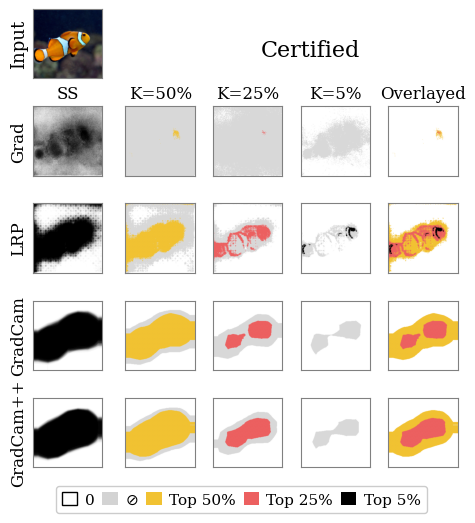

In [ ]:
# Config
fontsize = 14
font = {'family': 'serif', 'weight': 'normal', 'size': fontsize}
matplotlib.rc('font', **font)

# Layout setup
layers = ['Input']
which_im = image_indices[0]
rows_per_image, methods_per_row = 1, 1
methods_layout = [xai_methods[i:i + methods_per_row] for i in range(0, len(xai_methods), methods_per_row)]
col_types = ['mean sparsified'] + [f'K={K}' for K in Ks] + ['overlayed']
features = len(col_types) * len(layers)
num_rows = rows_per_image * len(methods_layout) + 1
num_cols = methods_per_row * features

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols, num_rows))
for ax in axes.flatten():
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    for spine in ax.spines.values():
            spine.set_edgecolor('gray')
axes[0,0].set_ylabel('Input', fontsize=fontsize-1, labelpad=10, rotation=90, ha='center', va='center')
for i in range(num_cols-1):
    axes[0, i+1].axis('off')
# Colors
sigma = sigmas[0]
greens = plt.cm.Greens
custom_greens = LinearSegmentedColormap.from_list("custom_greens", [(1, 1, 1)] + [greens(i) for i in range(greens.N)], N=greens.N)
color_list = [to_rgba(c) for c in ['#f1c232', '#ec6060', '#842E6A', '#271C48', '#000000'][:len(Ks)]]
color_list[-1] = to_rgba('black')
inferno_custom = ListedColormap(color_list, name="inferno_custom")
colors = {'abstain': (0.85, 0.85, 0.85, 1), 'bg': (1, 1, 1, 1), 'greens': custom_greens, 'inferno': inferno_custom, 'inferno_ls': color_list}

# Plotting loop
for layer_idx, layer in enumerate(layers):
    for super_row_idx, xai_subset in enumerate(methods_layout):
        for xai_idx, xai_method in enumerate(xai_subset):
            layer = 'Final' if 'Cam' in xai_method else 'Input'
            for idx, im_idx in enumerate(image_indices):
                if im_idx != which_im: continue
                row_idx = super_row_idx + 1
                image = images[im_idx].cpu().numpy().transpose(1, 2, 0)
                axes[0, 0].imshow(image)
                for col_i, col_type in enumerate(col_types):
                    col_idx = xai_idx * len(col_types) + col_i
                    ax = axes[row_idx, col_idx]
                    if col_type == 'mean sparsified':
                        K = Ks[0]
                        attr = graph_dict[sigma][layer][xai_method][K][n][tau]['sparsified'][idx].mean(0).squeeze()
                        ax.imshow(attr, cmap=plt.cm.binary_r)
                        ax.set_title('SS' if row_idx == 1 else '', fontsize=fontsize - 2)
                        label = {'GradCamPlusPlus': 'GradCam++', 'AblationCam': 'Abl.Cam'}.get(xai_method, xai_method)
                        ax.set_ylabel(label, fontsize=fontsize - 2)
                    elif col_type.startswith('K='):
                        K = int(col_type.replace('K=', ''))
                        cert = graph_dict[sigma][layer][xai_method][K][n][tau]['certified'][idx].squeeze()
                        rgb = get_certified_rgb(cert, cmap=colors['greens'], degrees=[[K]], abstain_color=colors['abstain'],
                                                certified_1_color=colors['inferno_ls'][col_i - 1], certified_0_color=colors['bg'])
                        ax.imshow(rgb)
                        if row_idx == 1: ax.set_title(f'K={K}%', fontsize=fontsize - 2)
                        if col_idx ==2 and row_idx == 1:
                            ax.text(1.4, 1.65, "Certified", fontsize=fontsize+2, ha='center', va='bottom', transform=ax.transAxes)

                    elif col_type == 'overlayed':
                        all_cert = np.zeros((img_dims[0] * scale, img_dims[1] * scale))
                        for deg_idx, K in enumerate(Ks):
                            cert = graph_dict[sigma][layer][xai_method][K][n][tau]['certified'][idx].squeeze()
                            all_cert[cert == 1] = deg_idx + 1
                        rgb = get_certified_rgb(all_cert, cmap=colors['inferno'], degrees=[[K] for K in Ks],
                                                abstain_color=colors['abstain'], certified_0_color=colors['bg'])
                        ax.imshow(rgb)
                        if row_idx == 1: ax.set_title('Overlayed', fontsize=fontsize - 2)

# Formatting
plt.tight_layout(rect=[0, 0, 1, 1])
plt.subplots_adjust(wspace=0.03, hspace=0.4)

# Adjust positions
for row in range(num_rows):
    for col in range(1, num_cols):
        pos = axes[row, col].get_position()
        axes[row, col].set_position([pos.x0 + 0.01, pos.y0, pos.width, pos.height])

# Legend
legend_elements = [
    mpatches.Patch(facecolor='white', edgecolor='black', label='0'),
    mpatches.Patch(facecolor='lightgray', label="$\oslash$")
] + [mpatches.Patch(facecolor=c, label=f'Top {K}%') for c, K in zip(color_list, Ks)]

fig.legend(handles=legend_elements, loc='upper center', ncol=(len(Ks) + 2), frameon=True,
           bbox_to_anchor=(0.52, 0.02), columnspacing=0.5, handletextpad=0.5, 
           labelspacing=0.5, fontsize=fontsize - 3, framealpha=1,
           handlelength=1.0, handleheight=1.0)
plt.savefig(f'{save_dir}/figure2.pdf', bbox_inches='tight')

plt.show()